In [5]:
import geopandas as gp
import sys
import numpy as np
import shapely
from shapely.geometry import LineString
from matplotlib import cbook
from matplotlib import cm
import matplotlib.pyplot as plt

sys.path.append("..")
import BayesianDrape

def null(*args,**kwargs):
    pass

In [6]:
def arrowplot(x,y,z,title,params=None,axis=None,xlabel=True,ylabel=True):
    if params is None:
        y_range = max(y)-min(y)
        z_range = max(z)-min(z)
        z_scale = y_range/z_range/2
    else:
        ax_min,ax_max,z_scale = params
    
    z_scaled = z*z_scale
    
    if params is None:
        highest = max(max(z_scaled+y),max(y))
        lowest = min(min(z_scaled+y),min(y))
        datarange = highest-lowest
        ax_max = highest+datarange/10
        ax_min = lowest-datarange/10
        
    
    if axis is None:
        _,ax1 = plt.subplots()
    else:
        ax1 = axis
    ax2 = ax1.twinx()

    # plot line graph
    ax1.plot(x, y)

    # plot arrows
    for i in range(len(x)):
        ax2.annotate("", xy=(x[i], y[i]+z_scaled[i]), xytext=(x[i], y[i]), textcoords='data', arrowprops=dict(arrowstyle="->"))
        ax2.annotate(f"{z[i]:.0f}", xy=(x[i], y[i]+z_scaled[i]), xytext=(x[i], y[i]+z_scaled[i]), textcoords='data')
        
    
    ax1.set_ylim([ax_min, ax_max])
    ax2.set_ylim([ax_min, ax_max])
    ax2.set_yticks([])
    ax1.set_title(title)
    #ax2.set_ylabel('Z data', color='g')

    #plt.show()
    #print(f"Arrows show likelihood gradient (log likelihood per meter adjustment of each elevation point) {z_scale=}")
    return (ax_min,ax_max,z_scale)

# sample data to test arrowplot function
x = np.arange(10)
y = np.random.rand(10)
z = np.random.rand(10)-.5
#print(x,y,z)
#arrowplot(x,y,z)

In [7]:
pf=null

def likgrad(terr1z,terr1y,terr1x,terr1road,zerr=0.25,nugget=0,iterno=0):
    model = BayesianDrape.build_model(terr1x,terr1y,terr1z,[terr1road],z_error_prior_scale=zerr,slope_continuity_param=0.5,print_callback=pf,nugget=nugget,gradient_smooth_window=1)
    out_drape,estimate,iterations = BayesianDrape.fit_model(model,iterno,print_callback=pf,differentiate=True,returnStats=True)
    ll = -model.minus_log_likelihood(estimate)
    grad = -model.minus_log_likelihood_gradient(estimate)
    
    return np.array(out_drape[0].coords),ll,grad.numpy(),iterations

#%matplotlib inline
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

def testcase(axes,ax_xindex,road_xs,terrain_zs,nugget=0,snapshots=None,iterations_to_capture=None):
    size = len(terrain_zs)
    ydist = 90
    xdist = 90
    terry = np.linspace(0,ydist,size)
    terrx = np.linspace(0,xdist,size)
    terrz=np.vstack([terrain_zs]*size).T*1.0
    
    road_pts = [(x,ydist/2) for x in road_xs]
    road = LineString(road_pts)

    if iterations_to_capture is None:
        _,_,_,iterations = likgrad(terrz.T,terry,terrx,road,nugget=nugget,iterno=20000)
        iterations_to_capture = np.linspace(0,iterations+1,snapshots)
    
    plot_params = None
    for ax_yindex,iteration in enumerate(iterations_to_capture):
        if ax_yindex<len(axes):
            out_drape,ll,grad,it_done = likgrad(terrz.T,terry,terrx,road,nugget=nugget,iterno=iteration)
            plot_params = arrowplot(out_drape[:,0],out_drape[:,2],grad,f"Iter. {it_done}, LL={ll:.0f}",plot_params,axis=axes[ax_yindex][ax_xindex])

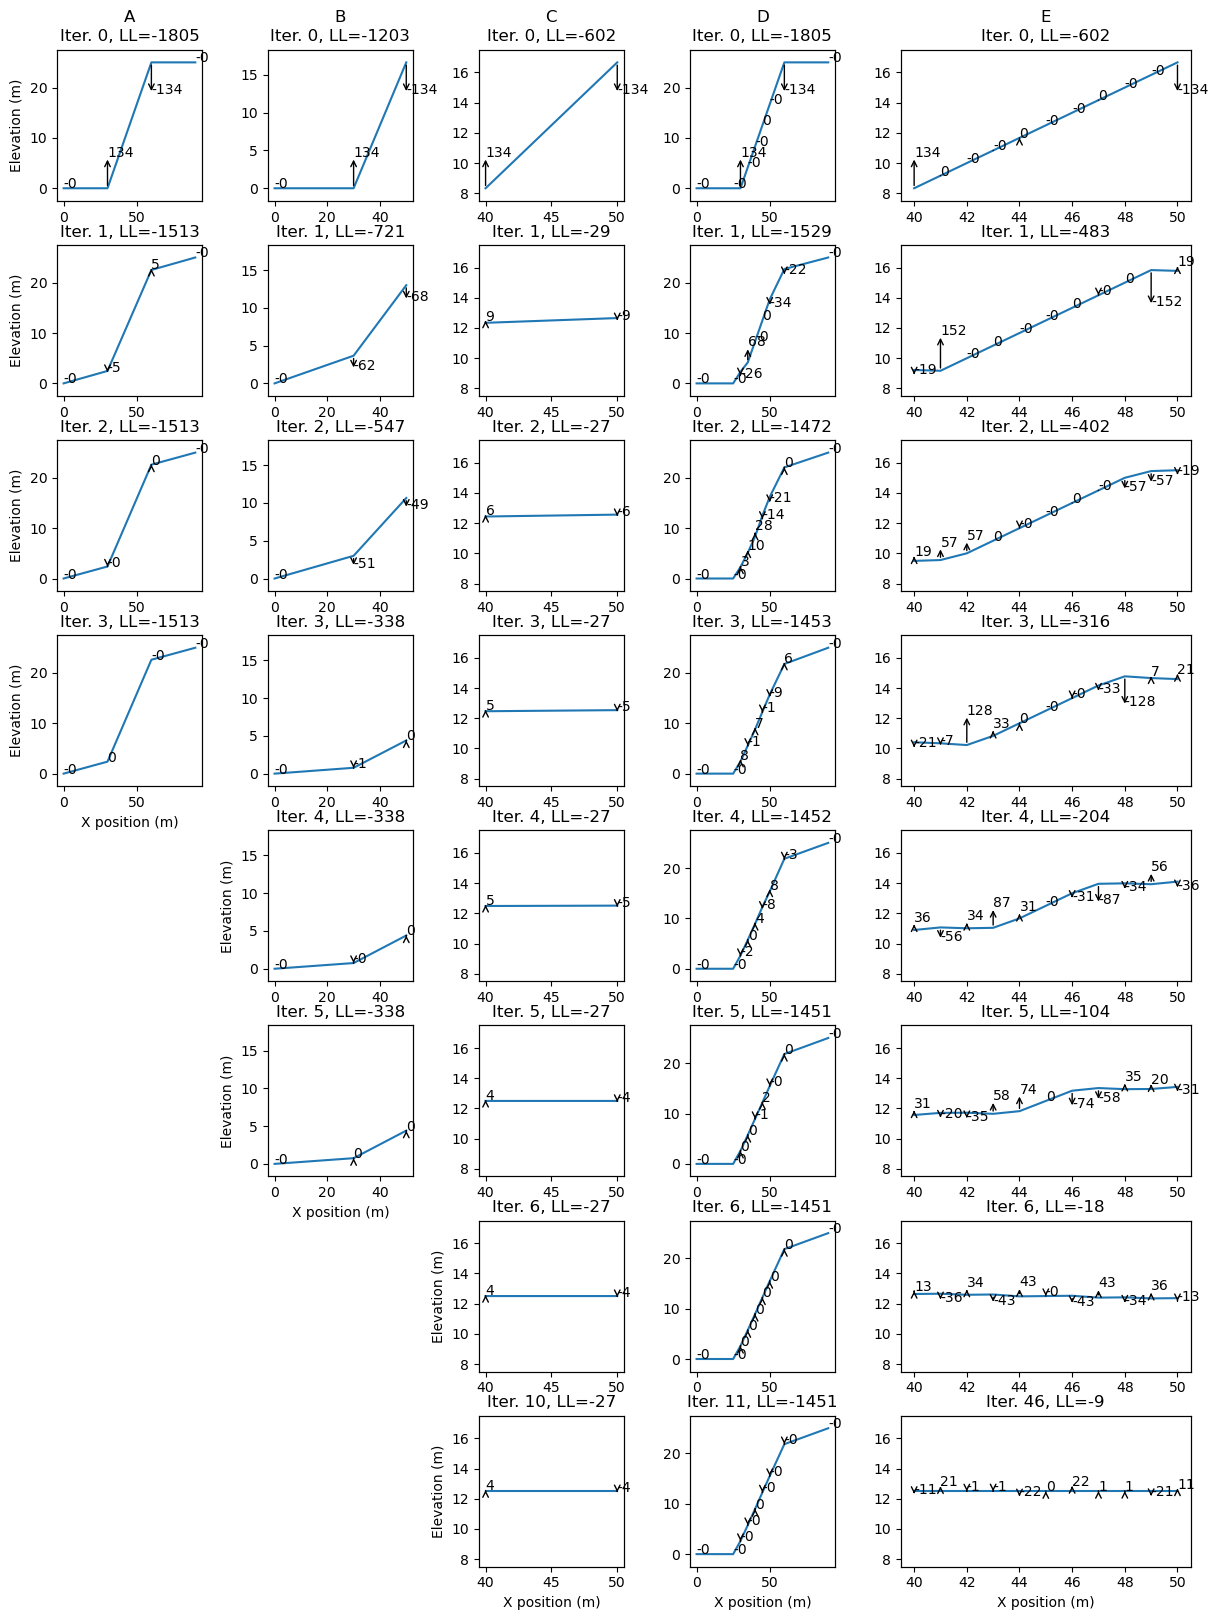

In [8]:
fig,ax = plt.subplots(8,5,figsize=(12,20*12/15),gridspec_kw={"width_ratios":[1,1,1,1,2]})

testcase(ax,0,[0,90],[0,0,25,25],nugget=0,iterations_to_capture=[0,1,2,3])
testcase(ax,1,[0,50],[0,0,25,25],nugget=0,iterations_to_capture=[0,1,2,3,4,5])
testcase(ax,2,[40,50],[0,0,25,25],nugget=0,iterations_to_capture=[0,1,2,3,4,5,6,47])
testcase(ax,3,[0,25,30,35,40,45,50,90],[0,0,25,25],nugget=0,iterations_to_capture=[0,1,2,3,4,5,6,47])
testcase(ax,4,[40,41,42,43,44,45,46,47,48,49,50],[0,0,25,25],nugget=0,iterations_to_capture=[0,1,2,3,4,5,6,100])

nplots_each_col = [4,6,8,8,8]
for col in range(5):
    for row in range(nplots_each_col[col],8):
        fig.delaxes(ax[row][col])
    ax[nplots_each_col[col]-1][col].set_xlabel("X position (m)")

ylabel_pos = [0,0,0,0,1,1,2,2]
for yi in range(8):
    ax[yi][ylabel_pos[yi]].set_ylabel("Elevation (m)")

for ax, col in zip(ax[0], "ABCDE"):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
fig.tight_layout(pad=0)
plt.show()